In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Integration analysis for PBMC

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.0 MB/s 
     |████████████████████████████████| 1.1 MB 76.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=9e2ea70da28d065f42db254075eaf27f09720e64e052a0e97de27c356fdcd3ea
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=29ab2302038f50d0733e4312de9f272c1adba4bc3dcbdb18f2e4647923d89330
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [ ]:
from IPython import display
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib import cm
from matplotlib.colors import Normalize 
from tensorflow import keras
import tensorflow as tf
import scipy.stats as stats
from tensorflow.keras import layers
import tensorflow_probability as tfp
from scipy.stats import gaussian_kde
import scipy.stats as stats
from sklearn.metrics import confusion_matrix
import seaborn as sns
import scipy
import umap
import os

#Load Data
Root_Folder = "/content/drive/MyDrive"
data = "pbmc"
data_parent_folder = "/Data"
code_parent_folder = "/scMVI"

os.chdir('/content/drive/My Drive/' + code_parent_folder +'/Code')

Acc_train = pd.read_pickle(Root_Folder + data_parent_folder + "/Data_ATAC/Acc_train_"+data+".pickle")
Rna_train = pd.read_pickle(Root_Folder + data_parent_folder + "/Data_ATAC/Rna_train_"+data+".pickle")

Acc_nrm_train = pd.read_pickle(Root_Folder + data_parent_folder + "/Data_ATAC/Nrm_acc_train_"+data+".pickle")
Rna_nrm_train = pd.read_pickle(Root_Folder + data_parent_folder + "/Data_ATAC/Nrm_rna_train_"+data+".pickle")

Acc_test = pd.read_pickle(Root_Folder + data_parent_folder + "/Data_ATAC/Acc_test_"+data+".pickle")
Rna_test = pd.read_pickle(Root_Folder + data_parent_folder + "/Data_ATAC/Rna_test_"+data+".pickle")

Acc_nrm_test = pd.read_pickle(Root_Folder + data_parent_folder + "/Data_ATAC/Nrm_acc_test_"+data+".pickle")
Rna_nrm_test = pd.read_pickle(Root_Folder + data_parent_folder + "/Data_ATAC/Nrm_rna_test_"+data+".pickle")


[Errno 2] No such file or directory: 'dir'
/content


In [ ]:
Acc_tr = tf.convert_to_tensor(Acc_train,dtype=tf.float32)
Rna_tr = tf.convert_to_tensor(Rna_train,dtype=tf.float32)

Acc_tst = tf.convert_to_tensor(Acc_test,dtype=tf.float32)
Rna_tst = tf.convert_to_tensor(Rna_test,dtype=tf.float32)

Acc_nrm_tr = tf.math.log(tf.convert_to_tensor(Acc_nrm_train,dtype=tf.float32))
Acc_nrm_tst = tf.math.log(tf.convert_to_tensor(Acc_nrm_test,dtype=tf.float32))

Rna_nrm_tr = tf.math.log(tf.convert_to_tensor(Rna_nrm_train,dtype=tf.float32))
Rna_nrm_tst = tf.math.log(tf.convert_to_tensor(Rna_nrm_test,dtype=tf.float32))

inp_sz_acc=Acc_tr.shape[1]
inp_sz_rna=Rna_tr.shape[1]

In [ ]:
Rna = pd.concat([Rna_train,Rna_test],axis=0)

Rna_comb = tf.concat([Rna_tr,Rna_tst],axis=0)
Acc_comb = tf.concat([Acc_tr,Acc_tst],axis=0)

Rna_nrm_comb = tf.concat([Rna_nrm_tr,Rna_nrm_tst],axis=0)
Acc_nrm_comb = tf.concat([Acc_nrm_tr,Acc_nrm_tst],axis=0)

In [ ]:
#Load PBMC metadata
if data == "pbmc":
    pbmc_QC = pd.read_csv(Root_Folder + data_parent_folder + "/Data_ATAC/Srt_annot.csv",'\t',index_col=[0])
    #pbmc_QC = pbmc_QC.loc[Rna.index]

    pbmc_QC_train = pbmc_QC.loc[Rna_train.index]
    pbmc_QC_test = pbmc_QC.loc[Rna_test.index]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
from Models import scMVI_10X
from Obj_Blocks import *

In [ ]:
#Define model and load weights for the trained model
mdl = scMVI_10X(inp_acc_dim=inp_sz_acc,inp_rna_dim=inp_sz_rna,intermidiate_dim=100,latent_dimensions=10)
mdl.load_weights(Root_Folder + code_parent_folder + "/Networks/scMVI_10X_"+data+"/scMVI_10X_"+data)

In [ ]:
lt_sp_acc,lt_sp_rna = mdl.get_latent([Acc_comb,Acc_nrm_comb,Rna_comb,Rna_nrm_comb])
lt_sp = mdl.comb_lt([lt_sp_acc,lt_sp_rna],'all')

lt_sp_acc_tr,lt_sp_rna_tr = mdl.get_latent([Acc_tr,Acc_nrm_tr,Rna_tr,Rna_nrm_tr])
lt_sp_acc_tst,lt_sp_rna_tst = mdl.get_latent([Acc_tst,Acc_tst,Rna_tst,Rna_nrm_tst])

In [ ]:
#Estimate latent space distances between training and test set samples for accessibility and expression layers
dist_lt_sp_tr_acc_rna = tf.math.sqrt(tf.reduce_sum(tf.math.square(lt_sp_acc_tr-lt_sp_rna_tr),axis=1))
dits_lt_sp_tr = dist_lt_sp_tr_acc_rna
dits_lt_sp_tr = dits_lt_sp_tr.numpy()

dist_lt_sp_tst_acc_rna = tf.math.sqrt(tf.reduce_sum(tf.math.square(lt_sp_acc_tst-lt_sp_rna_tst),axis=1))
dits_lt_sp_tst = dist_lt_sp_tst_acc_rna
dits_lt_sp_tst = dits_lt_sp_tst.numpy()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


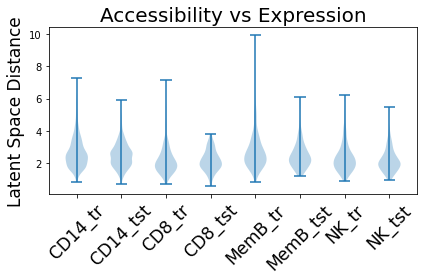

In [ ]:
#lbs = ['CD14_Mono','CD16_Mono','CD4_Naive','CD4_TCM','CD4_TEM','CD8_Naive','CD8_TEM_1','CD8_TEM_2','HSPC','Intermediate_B','MAIT','Memory_B','NK','Naive_B','Plasma','Treg','cDC','gdT','pDC']
lbs = ['CD14 Mono','CD8 TEM_2','Memory B','NK']
x_ticks =['CD14_tr','CD14_tst',"CD8_tr","CD8_tst",'MemB_tr','MemB_tst',"NK_tr","NK_tst"]
data = []

for ii in range(len(lbs)):
    data.append(dits_lt_sp_tr[pbmc_QC_train['seurat_annotation']==lbs[ii]])
    data.append(dits_lt_sp_tst[pbmc_QC_test['seurat_annotation']==lbs[ii]])

x_ticks_list = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0]
ax= plt.subplot()
ax.violinplot(data)
ax.set_xticks(x_ticks_list)
ax.set_xticklabels(x_ticks,rotation = 45,fontsize=17)
ax.set_title("Accessibility vs Expression",fontsize=20)
ax.set_ylabel("Latent Space Distance",fontsize=17)
plt.tight_layout()
#plt.savefig(Root_Folder + code_parent_folder + "/Paper_Plots/10X_dist_comp.png")
plt.show()

In [ ]:
reducer = umap.UMAP(random_state=0)

embedding = reducer.fit_transform(lt_sp)
embedding_rna = reducer.transform(lt_sp_rna)
embedding_acc = reducer.transform(lt_sp_acc)

In [ ]:
if data == "pbmc":
    time = ['CD14 Mono','CD16 Mono','CD4 Naive','CD4 TCM','CD4 TEM','CD8 Naive','CD8 TEM_1','CD8 TEM_2','cDC','gdT','HSPC','Intermediate B','MAIT','Memory B','Naive B','NK','pDC','Plasma','Treg']
    lb = []
    plt.rcParams["figure.figsize"] = (20,16)
    for ii in range(len(time)):
        plt.scatter(embedding[pbmc_QC['seurat_annotation']==time[ii],0],embedding[pbmc_QC['seurat_annotation']==time[ii],1])
        lb.append(time[ii])
    plt.legend(lb,fontsize=20)
    plt.title("scMVI latent space (PBMC)",fontsize=40)
    plt.axis('off')
    #plt.savefig(Root_Folder + code_parent_folder + "/Paper_Plots/scMVI_lt_" + data +".png")
    plt.show()

In [ ]:
if data == "pbmc":
                time = ['ATAC','RNA']
                lb = []
                plt.rcParams["figure.figsize"] = (10,8)
                plt.scatter(embedding_acc[:,0],embedding_acc[:,1])
                plt.scatter(embedding_rna[:,0],embedding_rna[:,1])
                plt.legend(time,fontsize=15)
                plt.title("scMVI latent space (PBMC)",fontsize=30)
                #plt.savefig(Root_Folder + code_parent_folder + "/Paper_Plots/scMVI_lt_int_"+data+".png")
                plt.show()
